In [1]:
"""2주차: k-NN 알고리즘 전체 파이프라인 (학생 학습 데이터 버전).

이 모듈은 2주차 차시 1~3에서 다루는 k-NN(k-Nearest Neighbors) 분류
실습 코드를 순차적으로 종합한 것입니다.

데이터: student_learning_data_kr.csv (학생 학습 활동 → 최종성적 예측)
환경: Google Colab
스타일: Google Python Style Guide

Contents:
    1. 데이터 로드 및 탐색 (차시 2)
    2. 전처리 — 범주형 인코딩 (차시 2)
    3. 훈련/테스트 분리 (차시 2)
    4. k-NN 모델 생성, 학습, 예측 (차시 2)
    5. 훈련 정확도 vs 테스트 정확도 비교 (차시 2)
    6. 여러 k값 실험 (차시 2~3)
    7. k값 체계적 실험 k=1~50 (차시 3)
    8. 그래프 시각화 및 패턴 분석 (차시 3)
"""

'2주차: k-NN 알고리즘 전체 파이프라인 (학생 학습 데이터 버전).\n\n이 모듈은 2주차 차시 1~3에서 다루는 k-NN(k-Nearest Neighbors) 분류\n실습 코드를 순차적으로 종합한 것입니다.\n\n데이터: student_learning_data_kr.csv (학생 학습 활동 → 최종성적 예측)\n환경: Google Colab\n스타일: Google Python Style Guide\n\nContents:\n    1. 데이터 로드 및 탐색 (차시 2)\n    2. 전처리 — 범주형 인코딩 (차시 2)\n    3. 훈련/테스트 분리 (차시 2)\n    4. k-NN 모델 생성, 학습, 예측 (차시 2)\n    5. 훈련 정확도 vs 테스트 정확도 비교 (차시 2)\n    6. 여러 k값 실험 (차시 2~3)\n    7. k값 체계적 실험 k=1~50 (차시 3)\n    8. 그래프 시각화 및 패턴 분석 (차시 3)\n'

# 2주차: k-NN 알고리즘 전체 파이프라인
### 📊 데이터: 학생 학습 활동 → 최종성적(A/B/C/D) 예측
---
## 차시 1 핵심 요약 (이론)
- k-NN 작동 원리: **거리 측정 → k개 선택 → 다수결 투표**
- 거리 측정: 유클리드 거리 (Euclidean Distance)
- k = **하이퍼파라미터** (사람이 학습 전에 설정하는 값)
- k ↓(작음): 민감, 복잡, 과적합 위험
- k ↑(큼): 둔감, 단순, 과소적합 위험

---
## Step 1. 라이브러리 임포트

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

---
## Step 2. 데이터 로드 및 탐색
- **데이터**: `student_learning_data_kr.csv`
- **피처 (14개 컬럼 중 13개)**:
  - 수치형 6개: 주당학습시간, 출석률, 나이, 온라인강좌수, 과제완료율, 시험점수
  - 범주형 7개: 비교과활동, 학습동기, 인터넷접근, 성별, 선호학습유형, 토론참여, 스트레스수준
- **타겟**: `최종성적` (A, B, C, D — 4개 클래스)

In [3]:
# Google Colab에서 파일 업로드 (이미 업로드된 경우 생략 가능)
# from google.colab import files
# uploaded = files.upload()

url = "https://raw.githubusercontent.com/SJ-EduLab/ML-for-Education/main/week01/student_learning_data_kr.csv"
df = pd.read_csv(url)

print(f"데이터 shape: {df.shape}")
print(f"컬럼 목록: {df.columns.tolist()}")
print()
df.head()

데이터 shape: (14003, 14)
컬럼 목록: ['주당학습시간', '출석률', '비교과활동', '학습동기', '인터넷접근', '성별', '나이', '선호학습유형', '온라인강좌수', '토론참여', '과제완료율', '시험점수', '스트레스수준', '최종성적']



,주당학습시간,출석률,비교과활동,학습동기,인터넷접근,성별,나이,선호학습유형,온라인강좌수,토론참여,과제완료율,시험점수,스트레스수준,최종성적
0,19,64,미참여,낮음,있음,여,19,읽기쓰기형,8,참여,59,40,낮음,D
1,19,64,미참여,낮음,있음,여,23,시각형,16,미참여,90,66,낮음,C
2,19,64,미참여,낮음,있음,여,28,운동감각형,19,미참여,67,99,낮음,A
3,19,64,참여,낮음,있음,여,19,읽기쓰기형,8,참여,59,40,낮음,D
4,19,64,참여,낮음,있음,여,23,시각형,16,미참여,90,66,낮음,C


In [4]:
# 타겟(최종성적) 분포 확인
print("=== 최종성적 분포 ===")
print(df["최종성적"].value_counts().sort_index())

=== 최종성적 분포 ===
최종성적
A    3832
B    3310
C    3618
D    3243
Name: count, dtype: int64


In [5]:
# 수치형 피처 기초 통계
print("=== 수치형 피처 기초 통계 ===")
df.describe()

=== 수치형 피처 기초 통계 ===


,주당학습시간,출석률,나이,온라인강좌수,과제완료율,시험점수
count,14003.000000,14003.000000,14003.000000,14003.000000,14003.000000,14003.000000
mean,19.987431,80.194316,23.532172,9.891952,74.502535,70.346926
std,5.890637,11.472181,3.514293,6.112801,14.632177,17.688113
min,5.000000,60.000000,18.000000,0.000000,50.000000,40.000000
25%,16.000000,70.000000,20.000000,5.000000,62.000000,55.000000
50%,20.000000,80.000000,24.000000,10.000000,74.000000,70.000000
75%,24.000000,90.000000,27.000000,15.000000,87.000000,86.000000
max,44.000000,100.000000,29.000000,20.000000,100.000000,100.000000


---
## Step 3. 전처리 — 범주형 피처 인코딩

k-NN은 **거리를 계산**하는 알고리즘이므로, 모든 피처가 숫자여야 합니다.
범주형 데이터(텍스트)를 숫자로 변환하는 과정이 필요합니다.

`LabelEncoder`: 각 범주를 0, 1, 2, ... 숫자로 변환

| 원본 | 인코딩 후 |
|------|-----------|
| 낮음 | 0 |
| 보통 | 1 |
| 높음 | 2 |

In [6]:
# 범주형 컬럼 목록
categorical_columns = [
    "비교과활동", "학습동기", "인터넷접근",
    "성별", "선호학습유형", "토론참여", "스트레스수준",
]

# LabelEncoder로 범주형 → 숫자 변환
df_encoded = df.copy()
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

비교과활동: {'미참여': np.int64(0), '참여': np.int64(1)}
학습동기: {'낮음': np.int64(0), '높음': np.int64(1), '보통': np.int64(2)}
인터넷접근: {'없음': np.int64(0), '있음': np.int64(1)}
성별: {'남': np.int64(0), '여': np.int64(1)}
선호학습유형: {'시각형': np.int64(0), '운동감각형': np.int64(1), '읽기쓰기형': np.int64(2), '청각형': np.int64(3)}
토론참여: {'미참여': np.int64(0), '참여': np.int64(1)}
스트레스수준: {'낮음': np.int64(0), '높음': np.int64(1), '보통': np.int64(2)}


---
## Step 4. 피처(X)와 타겟(y) 분리

In [7]:
# 피처: 최종성적을 제외한 나머지 13개 컬럼
X = df_encoded.drop("최종성적", axis=1).values

# 타겟: 최종성적 (A, B, C, D → 숫자 변환)
le_target = LabelEncoder()
y = le_target.fit_transform(df_encoded["최종성적"])

print(f"피처 shape: {X.shape}")
print(f"타겟 shape: {y.shape}")
print(f"타겟 클래스: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

피처 shape: (14003, 13)
타겟 shape: (14003,)
타겟 클래스: {'A': np.int64(0), 'B': np.int64(1), 'C': np.int64(2), 'D': np.int64(3)}


---
## Step 5. 훈련/테스트 분리
- `test_size=0.3`: 전체의 30%를 테스트 세트로 분리
- `random_state=42`: 재현성(reproducibility)을 위한 랜덤 시드 고정

**왜 나누는가?** → 모델의 **일반화 성능**(새 데이터에서의 진짜 실력)을 측정하기 위해

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"훈련 세트: {X_train.shape[0]}개")
print(f"테스트 세트: {X_test.shape[0]}개")

훈련 세트: 9802개
테스트 세트: 4201개


---
## Step 6. k-NN 모델 생성 · 학습 · 예측 (k=5)
- `n_neighbors=5`: 하이퍼파라미터 k를 명시적으로 설정
- `fit()`: 훈련 데이터로 학습 (k-NN은 데이터를 저장)
- `predict()`: 테스트 데이터에 대해 예측

In [9]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"테스트 정확도 (k=5): {accuracy:.4f}")

테스트 정확도 (k=5): 0.9626


---
## Step 7. 훈련 정확도 vs 테스트 정확도 비교
- 훈련 정확도: 이미 본 데이터에 대한 성능 (가짜 실력일 수 있음)
- 테스트 정확도: 본 적 없는 데이터에 대한 성능 (진짜 실력)

| 패턴 | 훈련 | 테스트 | 진단 |
|------|------|--------|------|
| 양호 | 높음 | 높음 | ✓ |
| 과적합 | 높음 | 낮음 | ⚠ |
| 과소적합 | 낮음 | 낮음 | ✗ |

In [10]:
train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)

print(f"훈련 정확도 (k=5): {train_accuracy:.4f}")
print(f"테스트 정확도 (k=5): {accuracy:.4f}")
print(f"간격 (gap):          {train_accuracy - accuracy:.4f}")

훈련 정확도 (k=5): 0.9811
테스트 정확도 (k=5): 0.9626
간격 (gap):          0.0185


---
## Step 8. 여러 k값 실험 (차시 2 — 6개 k값)
- 동일한 훈련/테스트 분리에서 k만 변경 → **공정한 비교**
- `train_test_split`은 for문 바깥에서 1회만 실행

In [11]:
k_values = [1, 3, 5, 7, 9, 15]

print(f"{'k':>3} | {'훈련 정확도':>10} | {'테스트 정확도':>10}")
print("-" * 35)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, knn.predict(X_train))
    test_acc = accuracy_score(y_test, knn.predict(X_test))

    print(f"{k:>3} | {train_acc:>10.4f} | {test_acc:>10.4f}")

  k |     훈련 정확도 |    테스트 정확도
-----------------------------------
  1 |     1.0000 |     0.9845
  3 |     0.9905 |     0.9695
  5 |     0.9811 |     0.9626
  7 |     0.9718 |     0.9541
  9 |     0.9626 |     0.9500
 15 |     0.9540 |     0.9479


---
## Step 9. k값 체계적 실험 k=1~50 (차시 3)
- 넓은 범위의 k값을 촘촘하게 실험
- 훈련/테스트 정확도를 리스트에 저장

In [12]:
k_range = range(1, 51)
train_accuracies = []
test_accuracies = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, knn.predict(X_train))
    train_accuracies.append(train_acc)

    test_acc = accuracy_score(y_test, knn.predict(X_test))
    test_accuracies.append(test_acc)

---
## Step 10. 그래프 시각화 — k값에 따른 정확도 변화
- x축: k값 (이웃 수)
- y축: 정확도
- 파란 선: 훈련 정확도 / 주황 선: 테스트 정확도

### 그래프 해석 3구간
| 구간 | k 범위 | 특징 | 진단 |
|------|--------|------|------|
| A | k 작음 | 훈련↑ 테스트↓, gap 큼 | 과적합 |
| B | k 적절 | 둘 다 높음, gap 작음 | 양호 (sweet spot) |
| C | k 큼 | 둘 다 낮음 | 과소적합 |

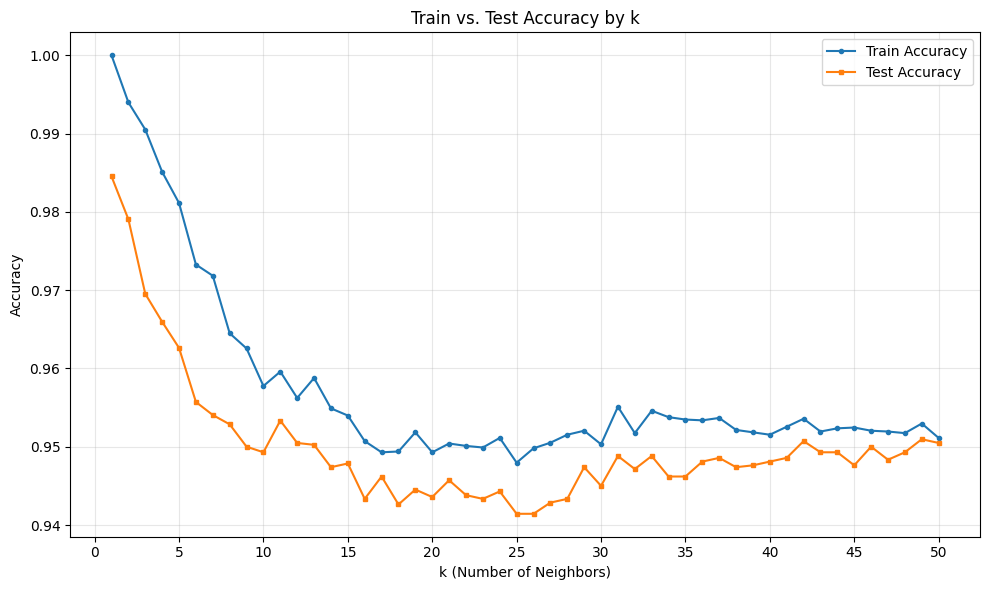

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(
    list(k_range),
    train_accuracies,
    label="Train Accuracy",
    marker="o",
    markersize=3,
)
plt.plot(
    list(k_range),
    test_accuracies,
    label="Test Accuracy",
    marker="s",
    markersize=3,
)
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy")
plt.title("Train vs. Test Accuracy by k")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 51, 5))
plt.tight_layout()
plt.show()

---
## Step 11. 최적 k값 확인

In [15]:
best_k = list(k_range)[test_accuracies.index(max(test_accuracies))]
best_test_acc = max(test_accuracies)
best_train_acc = train_accuracies[list(k_range).index(best_k)]

print(f"테스트 정확도가 가장 높은 k: {best_k}")
print(f"해당 훈련 정확도: {best_train_acc:.4f}")
print(f"해당 테스트 정확도: {best_test_acc:.4f}")
print(f"차이 (gap): {best_train_acc - best_test_acc:.4f}")
print()
print("⚠ 주의: 이 결과는 random_state=42에서의 단일 분할 결과입니다.")
print("  random_state를 바꾸면 최적 k도 달라질 수 있습니다.")
print("  더 안정적인 평가 → 4주차 교차검증(Cross-Validation)")

테스트 정확도가 가장 높은 k: 1
해당 훈련 정확도: 1.0000
해당 테스트 정확도: 0.9845
차이 (gap): 0.0155

⚠ 주의: 이 결과는 random_state=42에서의 단일 분할 결과입니다.
  random_state를 바꾸면 최적 k도 달라질 수 있습니다.
  더 안정적인 평가 → 4주차 교차검증(Cross-Validation)
